In [3]:
import cProfile
import tensorflow as tf
# turn of warning messages
tf.get_logger().setLevel('ERROR')

import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras import callbacks as callbacks_module
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer
from keras.losses import Loss, mse
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import  plot_model

from keras.engine import data_adapter
import keras.backend

np.random.seed(1234)
tf.random.set_seed(1234)

In [4]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )


# PINN : Two-Dimensional Navier-Strokes Equation

The Navier-Stokes equations offer a robust mathematical framework for analyzing the motion of viscous fluids, such as liquids and gases. Deriving from Newton's second law of motion, these equations incorporate the impact of a pressure term (the gradient of pressure) and a diffusing viscous term (related to the Laplacian of velocity), signifying that the stress in the fluid arises from these aspects. The Navier-Stokes equations bear immense importance for the scientific and engineering realm, modeling diverse phenomena such as weather patterns, ocean currents, water flow in pipes, and airflow around a wing. By contributing to the design of aircraft and cars, the analysis of blood flow, the structure of power stations, and the dispersion of pollutants, they take on varied applications.

The Navier-Stokes equations for incompressible flows, where the fluid density remains unchanged, are expressed as:

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}$$

This equation contains different components representing specific fluid dynamics aspects. The term $\frac{\partial \mathbf{u}}{\partial t}$ signifies the change in velocity over time, capturing unsteady effects. The convective term $(\mathbf{u} \cdot \nabla) \mathbf{u}$ represents the interaction of fluid with itself as it moves and reshapes, accounting for fluid inertia. The pressure gradient term, $-\frac{1}{\rho} \nabla p$, denotes the fluid pressure variation across the flow. The diffusion term, $\nu \nabla^2 \mathbf{u}$, characterizes the momentum diffusion due to internal friction, symbolizing the viscous effects. Lastly, $\mathbf{f}$ represents the influence of external body forces, such as gravity, on the fluid per unit volume.

In the context of two-dimensional flows, the Navier-Stokes equations transform into two coupled partial differential equations:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$$

$$\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)$$

In these equations, $u$ and $v$ represent the velocity components in the $x$ and $y$ directions respectively, $p$ is the pressure, and $t$ signifies time. The left side of the momentum equations encompasses unsteady and convective effects that hinge on the fluid's velocity, spatial position, and time. The right side encompasses the effects of the pressure gradient and viscous diffusion.

The Physics Informed Neural Network (PINN) is proposed to resolve the inverse problem for incompressible fluid flow as described by the Navier-Stokes equation. This approach considers the following two-dimension equation:

$$\frac{\partial u}{\partial t} + \lambda_1 (u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}) = - \frac{\partial p}{\partial x} + \lambda_2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$$

$$\frac{\partial v}{\partial t} + \lambda_1 (u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}) = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \lambda_2 \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)$$

In these equations, $u(x,y,t)$ signifies the $x$ component of the velocity field, $v(x,y,t)$ denotes the $y$ component, and $p(x,y,t)$ symbolizes the pressure. Here, $\lambda =(\lambda_1, \lambda_2)$ are the sought-after unknown parameters for the inverse problem.

The continuity equation embodies one of the fundamental principles of physics: conservation of mass. It dictates that the mass within a system must remain constant over time, barring any inflow or outflow of matter. In the context of fluid dynamics and specifically for incompressible flow, this principle simplifies to the mathematical condition you've written:

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

This equation ensures that the mass flowing into any point equals the mass flowing out, preventing mass creation or destruction. This property is intrinsic to incompressible fluids, a critical assumption in many practical fluid dynamics problems where density changes minimally.

To facilitate satisfying this condition, we introduce a special mathematical tool, the stream function $\psi( x, y, t)$. This function is designed so its derivatives define the velocity field components:

$$u = \frac{\partial \psi}{\partial y},~~~~v = - \frac{\partial \psi}{\partial x}$$

This transformation guarantees that the velocity field thus defined inherently satisfies the continuity equation, ensuring that any solution to the Navier-Stokes equations respects mass conservation.

On a practical level, the stream function provides valuable insights into flow patterns. Specifically, in two-dimensional flow, the difference in stream function values between two points equates to the volume flow rate, or "flux," between them. This enables a potent visual representation of the flow field: lines of constant $\psi$ (streamlines) correspond directly to the trajectories of fluid particles.

We focus on the classic problem of incompressible flow past a circular cylinder, a scenario known to exhibit intricate dynamic behavior and transitions across different Reynolds number regimes $\text{Re} = u_\infty D/ν =100$. With a non-dimensional free-stream velocity $u_\infty = 1$, cylinder diameter $D = 1$, and kinematic viscosity $\nu = 0.01$, the system showcases periodic steady-state behavior characterized by an asymmetric vortex shedding pattern, known as the Kármán vortex street, in the cylinder wake.

To generate a high-resolution dataset for this problem, the authors utilized the spectral/hp-element solver NekTar. They assumed a uniform free-stream velocity profile at the left boundary, a zero-pressure outflow condition at the right boundary (located 25 diameters downstream of the cylinder), and periodicity for the top and bottom boundaries of the $[−15, 25] \times [−8, 8]$ domain.

The objective is to identify the unknown parameters $\lambda_1$ and $\lambda_2$, and also to achieve a qualitatively accurate reconstruction of the entire pressure field $p(x, y, t)$ in the cylinder wake, which can only be identified up to a constant by definition, given scattered and potentially noisy data on the stream-wise $u(x, y, t)$ and transverse $v( x, y, t)$ velocity components. For this purpose, we have created a training dataset by randomly sub-sampling the full high-resolution dataset.

# Optimizer L-BFGS-B : Class

In [5]:
class L_BFGS_B:
    def __init__(self, 
                 model , 
                 x_train, 
                 y_train, 
                 loss_func,
                 factr: float = 1e7, 
                 m: int=50, 
                 maxls: int=50, 
                 maxiter: int=5000):
        """
        Initialize the L-BFGS-B optimizer with given model, data, loss function, and optimization parameters.

        Args:
            model: The model to be optimized.
            x_train: The input data (features) for training.
            y_train: The output data (labels) for training.
            loss_func: The loss function to be minimized during training.
            factr: The optimization parameter for L-BFGS-B (default: 1e7).
            m: The number of limited memory vectors for L-BFGS-B (default: 50).
            maxls: The maximum number of line search steps for L-BFGS-B (default: 50).
            maxiter: The maximum number of iterations for L-BFGS-B (default: 5000).
        """
   
        
        # Initialize the L-BFGS-B optimizer with given model, data, loss function, and optimization parameters
        self.model = model
        self.loss_func = loss_func
        self.loss_tracker = None
        self.current_step = 0
        
        # Convert training data to tensors
        self.x_train = tf.constant(x_train, dtype=tf.float32) 
        self.y_train = tf.constant(y_train, dtype=tf.float32)

         # Store optimization parameters
        self.factr = factr
        self.m = m
        self.maxls = maxls 
        self.maxiter = maxiter
        self.metrics = ['loss']

        # Initialize the progress bar for displaying optimization progress
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':self.maxiter, 'steps':1, 'metrics':self.metrics})
   
    def set_weights(self, weights_1d):
        """
        Set the model's weights using a 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.
        """
        #Set the model's weights using a 1D array of weights
        weights_shapes = [ w.shape for w in self.model.trainable_weights ]
        printest('weights_shapes', weights_shapes)
        n = [0] + [ np.prod(shape) for shape in weights_shapes ] 
        partition = np.cumsum(n) 
        weights = [ weights_1d[from_part:to_part].reshape(shape)
                        for from_part, to_part, shape 
                        in zip(partition[:-1], partition[1:], weights_shapes) ]
        
        for w, new_w in zip(self.model.trainable_weights, weights):
            w.assign(new_w)                
        #self.model.set_weights(weights)
    
    @tf.function
    def tf_evaluate(self, x_train, y_train):
        """
        Compute the model's loss and gradients for the given input (x) and output (y) tensors.

        Args:
            x: Input tensor.
            y: Output tensor.

        Returns:
            loss: The computed loss.
            grads: The computed gradients.
        """
        with tf.GradientTape() as tape:
            # Compute the model's loss and gradients for the given input (x) and output (y) tensors
            y_pred = self.model(x_train)
            # Calculate the loss using the provided loss function
            loss = self.loss_func(y_train,  y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights, unconnected_gradients = tf.UnconnectedGradients.ZERO)
        #printest('loss', loss)
        #printest('weights len',len(self.model.trainable_weights))
        #printest('weights',self.model.trainable_weights)
        #printest('grads len', len(grads))
        #printest('grads', grads)
        return loss, grads
    
    def evaluate(self, weights_1d):
        """
        Evaluate the model's loss and gradients using the given 1D array of weights.

        Args:
            weights_1d: A 1D numpy array representing the weights of the model.

        Returns:
            loss: The computed loss.
            grads_concat: The computed gradients concatenated as a 1D numpy array.
        """
        # Evaluate the model's loss and gradients using the given 1D array of weights
        self.set_weights(weights_1d)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)

        # Convert the loss and gradients to numpy arrays for use with the L-BFGS-B optimizer
        loss = loss.numpy().astype('float64') 
        grads_concat = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        #printest('grads_concat', grads_concat)
        self.loss_tracker = loss
        return loss, grads_concat
    
    def callback(self,_):
        """
        Callback function to execute custom actions during optimization.

        Args:
            _: Unused argument for compatibility with the optimizer's callback signature.
        """
        # Update the progress bar at the specified interval
        update_interval = 1000
        if self.current_step % update_interval == 0:
            self.progbar.on_epoch_begin(self.current_step)
            loss = self.loss_tracker
            self.progbar.on_epoch_end(self.current_step, logs= {"loss":loss})
            
        self.current_step += 1

    def train(self):
        """
        Train the model using the L-BFGS-B optimization algorithm.
        """
        # First, call the model on the training data to initialize it
        self.model(self.x_train)
        # Then, get the initial weights of the model as a 1D array

        initial_weights = np.concatenate([ w for w in self.model.trainable_weights ])
        printest('initial_weights', initial_weights)
        
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))

        self.progbar.on_train_begin()
        # Train the model using L-BFGS-B optimization
        fmin_l_bfgs_b(  func=self.evaluate, x0=initial_weights, factr=self.factr,
                        m=self.m, maxls=self.maxls, maxiter=self.maxiter, callback=self.callback )
        self.progbar.on_train_end()

# Automatic Diff: Layer

In [6]:
class AutomaticDiff(Layer):

    def __init__(self, dnn):
        
        self.dnn = dnn
        self.lambda_1 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], trainable=True, dtype=tf.float32)
        super().__init__()
    
    def call(self, xyt): 
        with tf.GradientTape(persistent = True) as g:
            x = xyt[:,0:1]       
            y = xyt[:,1:2]        
            t = xyt[:,2:3]                 
            g.watch(x)
            g.watch(y)
            g.watch(t)
            xyt = tf.concat([x, y, t], 1)
            p_psi = self.dnn(xyt)
            p = p_psi[:,0:1]
            psi = p_psi[:,1:2]

            v = -g.gradient(psi, x)  ## (5000, 2, 3)
            u = -g.gradient(psi, y)


            dp_dx = g.gradient(p, x)
            dp_dy = g.gradient(p, y)

            du_dt = g.gradient(u, t)            
            du_dx = g.gradient(u, x)
            du_dy = g.gradient(u, y)

            dv_dt = g.gradient(v, t)
            dv_dx = g.gradient(v, x)
            dv_dy = g.gradient(v, y)
            
            d2u_dx2 = g.gradient(du_dx, x)          
            d2u_dy2 = g.gradient(du_dy, y)   
            d2v_dx2 = g.gradient(dv_dx, x)           
            d2v_dy2 = g.gradient(dv_dy, y)   
        #-------------------------------------------------------------------
        del g
        
        f_u = du_dt + self.lambda_1*(u*du_dx + v*du_dy) + dp_dx - self.lambda_2*(d2u_dx2 + d2u_dy2)   
        f_v = dv_dt + self.lambda_1*(u*dv_dx + v*dv_dy) + dp_dy - self.lambda_2*(d2v_dx2 + d2v_dy2)

        return (u, v, f_u, f_v)

# Dense Neural Network (DNN): Model

In [7]:
class DNN(Model):
    def __init__(self,
                 layer_units: list = [20, 20, 20, 20, 20, 20, 20, 20],
                 output_unit: int = 2,
                 activation_func: str = 'tanh',
                 initializer: str = "glorot_normal",
                 name="DNN"):
        """
        Initialize the DNN (Deep Neural Network) layer.

        Args:
            layer_units: A list of integers representing the number of units in each hidden layer .
            output_unit: An integer representing the number of units in the output layer .
            activation_func: A string representing the activation function used in the hidden layers .
            initializer: A string representing the kernel initializer used for the layers .
            name: A string representing the name of the layer.
        """
        super().__init__(name=name)

        self.units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.initializer = initializer

        # Hidden layers
        self.hidden_layer = []
        count = 0
        for unit in layer_units:
            self.hidden_layer.append(Dense(units=unit,
                                           kernel_initializer=self.initializer,
                                           activation=activation_func,
                                           name='Hidden_{}'.format(count)))
            count += 1

        # Output layer
        self.output_layer = Dense(units=output_unit,
                                  kernel_initializer=self.initializer,
                                  name="Output")

    def call(self, x):
        """
        Compute the forward pass of the DNN layer.

        Args:
            x: A tensor of shape (batch_size, input_dim), where input_dim is the dimension of the input features.

        Returns:
            x: A tensor of shape (batch_size, output_unit), containing the output of the DNN layer.
        """
        # Pass the input through the hidden layers
        for hidden in self.hidden_layer:
            x = hidden(x)

        # Pass the output of the hidden layers through the output layer
        x = self.output_layer(x)

        return x

# Physics Informed Neural Network (PINN): Model

In [8]:
class PINN(Model):
    def __init__(self,
                  dnn: DNN,
                  name: str =  'PINN'):
        super().__init__(name = name)

        """
        Initialize the Physics-Informed Neural Network (PINN) model.

        Args:
            dnn (DNN): A deep neural network object to use as the base model.
            nu (float, optional): The parameter nu used in the PDE equation. Defaults to 0.01/np.pi.
            name (str, optional): The name of the model. Defaults to 'PINN'.
        """
        
        # Initialize the DNN and automatic differentiation objects
        self.dnn = dnn
        self.auto_diff = AutomaticDiff(self.dnn)
        # Initialize loss trackers for metrics
        
    # Define metrics property to return the loss trackers
    @property
    def metrics(self):
        """
        Return the list of loss trackers used in the model.
        """
        if not hasattr(self, 'loss_tracker'):
            self.loss_tracker = Mean(name="loss")
        return [self.loss_tracker] 

    def call(self, x_train): 
        """
        Compute the model outputs for the given inputs.

        Args:
            x_train (tuple): A tuple containing the input data for equation, initial conditions, and boundary conditions.

        Returns:
            tuple: The computed residuals, initial conditions, and boundary conditions.
        """    

        # Compute residuals using the automatic differentiation (AD)
        u, v, f_u, f_v= self.auto_diff(x_train)
       
        return (u, v, f_u, f_v)
    
    # Train step function
    def train_step(self, data):
        """
        Train the model for one step using the given input and target data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        return self._process_step(data)
    
    # Define a function to compute the loss and gradients for the current batch of data
    @tf.function
    def tf_evaluate_loss_grads(self, x_train, y_train):
        """
        Evaluate the loss and gradients for the given input and target data.

        Args:
            x (tf.Tensor): The input data.
            y (tf.Tensor): The target data.

        Returns:
            tuple: The loss and gradients for the given input and target data.
        """

        with tf.GradientTape() as tape:
            y_pred = self(x_train)
            loss = self.compute_loss(y_train, y_pred)
        grads = tape.gradient(loss, self.trainable_weights)
        #printest('grads', grads)
        #printest('self.trainable_weights', self.trainable_weights)
        return loss, grads
    
    # Helper function to process one batch of data
    def _process_step(self, data):
        """
        Helper function to process one batch of data.

        Args:
            data (tuple): A tuple containing the input data and target data.

        Returns:
            dict: A dictionary containing the loss value for this training step.
        """
        x_train, y_train = data
        loss, grads = self.tf_evaluate_loss_grads(x_train, y_train)
        #if no other optimizer is choose and use_l_bfgs_b_optimizer = True
        # then self.optimizer = None and this is skipped
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.loss_tracker.update_state(loss)
    
        # Return the losses as a dictionary
        return {"loss": self.loss_tracker.result()}
    
    def compute_loss(self, y_train, y_pred):
        """
        Compute the loss between the predicted and target values.

        Args:
            y_train (tf.Tensor): The target data.
            y_pred (tf.Tensor): The predicted data.

        Returns:
            tf.Tensor: The computed loss.
        """
        u_pred, v_pred, f_u_pred, f_v_pred = y_pred[0], y_pred[1], y_pred[2], y_pred[3]
        u_train,v_train = y_train[:,0:1], y_train[:,1:2]

        #u_train, u_pred = uv_train[:,0:1], uv_pred[:,0:1]
        loss_1 =  tf.reduce_sum(tf.square(u_train - u_pred))
        
        #v_train, v_pred = y_train[:,1:2], uv_pred[:,1:2]
        loss_2 =  tf.reduce_sum(tf.square(v_train - v_pred))
        
        #f_u_pred, f_v_pred = f_uv_pred[:,0:1], f_uv_pred[:,1:2]
        loss_3 =  tf.reduce_sum(tf.square(f_u_pred)) + tf.reduce_sum(tf.square(f_v_pred))
        
        loss = loss_1 + loss_2 + loss_3
        return loss
        

    def custom_fit(self, x, y, epochs = 1, batch_size = None, shuffle = True, use_l_bfgs_b_optimizer = True, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Custom fit function for the PINN model. This method allows the use of the L-BFGS-B optimizer, which is a popular choice for
        solving partial differential equations with neural networks due to its ability to handle large-scale optimization problems
        efficiently. By providing the option to use the L-BFGS-B optimizer, this custom fit function enables better convergence
        and potentially faster training for the PINN model.

        The input data (x) and target data (y) should be provided as tuples of tensors, where each element in the tuple corresponds
        to a specific type of training data:

        x_train = (xt, xt_0, xt_bnd)
        y_train = (r, u_0, u_bnd)

        Args:
            x (tuple): The input data as a tuple of tensors (xt, xt_0, xt_bnd).
            y (tuple): The target data as a tuple of tensors (r, u_0, u_bnd).
            epochs (int, optional): The number of epochs to train the model. Defaults to 1.
            batch_size (int, optional): The batch size to use during training. Defaults to None.
            shuffle (bool, optional): Whether to shuffle the data before each epoch. Defaults to True.
            use_l_bfgs_b_optimizer (bool, optional): Whether to use the L-BFGS-B optimizer for training. Defaults to True.
            factr (float, optional): The L-BFGS-B factr parameter. Defaults to 1e7.
            m (int, optional): The L-BFGS-B m parameter. Defaults to 50.
            maxls (int, optional): The L-BFGS-B maxls parameter. Defaults to 50.
            maxiter (int, optional): The L-BFGS-B maxiter parameter. Defaults to 5000.

        Returns:
            if use_l_bfgs_b_optimizer = False return tf.keras.callbacks.History: A History object that records the training loss values.
        """

        if use_l_bfgs_b_optimizer:
            # Custom L_BFGS_B  Optimizer
            l_bfgs_b_optimizer = L_BFGS_B(model = self, x_train=x, y_train=y, loss_func = self.compute_loss, factr=factr, m=m, maxls=maxls, maxiter=maxiter)
            l_bfgs_b_optimizer.train()

        # Only used if using l_bfgs_b_optimizer = False
        if not use_l_bfgs_b_optimizer:
            # I use data_adapter.get_data_handler similar to the standard fit method
            # Create a data handler using the input data and provided parameters
            data_handler = data_adapter.get_data_handler(
                                            x=x,
                                            y=y,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            shuffle=shuffle,
                                            model=self
                                        )
            verbose = 1
            # I use callbacks_module.CallbackList similar to the standard fit method
            # Create a callback list to manage the training process and display progress
            callbacks = callbacks_module.CallbackList(
                            None,
                            add_history=True,
                            add_progbar=verbose != 0,
                            model=self,
                            verbose=verbose,
                            epochs = epochs,
                            steps=data_handler.inferred_steps,
                        )
            
            callbacks.on_train_begin()
            # data_handler.enumerate_epochs generate a iterator and epochs
            for epoch, data_iterator in data_handler.enumerate_epochs():
                self.reset_metrics()  
                callbacks.on_epoch_begin(epoch)  
                for step in data_handler.steps():            
                    callbacks.on_train_batch_begin(step)
                    # Get the current batch of data from the data_iterator
                    (x_batch, y_batch) = next(data_iterator)
                    # Perform one training step with the current batch of data
                    logs = self.train_step((x_batch, y_batch))     
                    callbacks.on_train_batch_end(step, logs)   
                
                # End the current epoch and update the logs             
                callbacks.on_epoch_end(epoch, logs)
            callbacks.on_train_end()
            return callbacks._history

# Main

In [23]:
n_train = 5000
n_test = 5000

# load dictionary Data
# keys: 'X_star: [x, y]', 'U_star : [u, v]', 'p_star : [p]', 't : [t]',
data = loadmat('./Data/cylinder_nektar_wake.mat')

# Rearrange Data                        shapes:
uv = data['U_star']                 # (5000, 2, 200) - N x 2 X T
u = uv[:,0,:]                       # (5000, 200)     - N x T
v = uv[:,1,:]                       # (5000, 200)     - N x T

# N = 5000, T = 200
N,T = (uv.shape[0], uv.shape[2]) 

xy = data['X_star']                 # (5000, 2)      - N x 2
x = np.tile(xy[:, 0:1], (1,T))      # (5000, 200)    - N x T
y = np.tile(xy[:, 1:2], (1,T))      # (5000, 200)    - N x T

t = data['t']                       # (200 , 1)      - T x 1
tt = np.tile(t, (1,N)).T             # (5000, 200)     - N x T
p = data['p_star']                  # (5000, 200)     - N x T

# 1D arrays : (10000, 1) - NT x 1
x_1d = x.flatten()[:,None]
y_1d = y.flatten()[:,None]
t_1d = tt.flatten()[:,None]

u_1d = u.flatten()[:,None]          
v_1d = v.flatten()[:,None]          
p_1d = p.flatten()[:,None]

# Training Data : (5000, 1)
indices = np.random.choice(N*T, n_train, replace = False)
xyt_train = np.concatenate( (x_1d[indices], y_1d[indices], t_1d[indices]), axis = 1)
uv_train  = np.concatenate( (u_1d[indices], v_1d[indices]), axis = 1) 

x_train = xyt_train
y_train = uv_train 

In [30]:
dnn = DNN([20,20,20,20,20])
pinn = PINN(dnn)

pinn.compile(optimizer=Adam(learning_rate = 0.0001))
pinn.custom_fit(x_train, y_train, batch_size = 32, epochs = 10,   use_l_bfgs_b_optimizer = False)

Epoch 1/10
157/157 [==============================] - 9s 23ms/step - loss: 22.9143
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 12.6240
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 9.8896
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 8.7740
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 7.9452
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 7.2564
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 6.6582
Epoch 8/10
157/157 [==============================] - 1s 6ms/step - loss: 6.1349
Epoch 9/10
157/157 [==============================] - 1s 7ms/step - loss: 5.6705
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 5.2367


In [11]:
#pinn.custom_fit(x_train, y_train, use_l_bfgs_b_optimizer = True)

## Plot

In [25]:
# Data test
snapshot = [100]         # state of a system at a particular point in time
x_test = xy[:,0:1]
y_test = xy[:,1:2]
t_test = tt[:,snapshot]

xyt_test = tf.concat( (x_test, y_test, t_test), axis = 1)

u_test = uv[:,0,snapshot]
v_test = uv[:,1,snapshot]

uv_test = tf.concat( (u_test, v_test), axis = 1)
p_test = p[:,snapshot]

# predict
p_psi = dnn.predict(xyt_test, batch_size = len(xyt_test))

1/1 [==============================] - 0s 466ms/step


In [26]:
min_val = xy.min(0)
max_val = xy.max(0)
n_points = 200

x = np.linspace(min_val[0], max_val[0], n_points)
y = np.linspace(min_val[1], max_val[1], n_points)
X, Y = np.meshgrid(x,y)

P_pred = griddata(xy, p_psi[:,1].flatten(), (X,Y) , method = "cubic")
Psi_pred = griddata(xy, p_psi[:,0].flatten(), (X,Y) , method = "cubic")
P_exact = griddata(xy, p_test.flatten(), (X, Y), method='cubic')

Text(0.5, 1.0, 'Exact pressure')

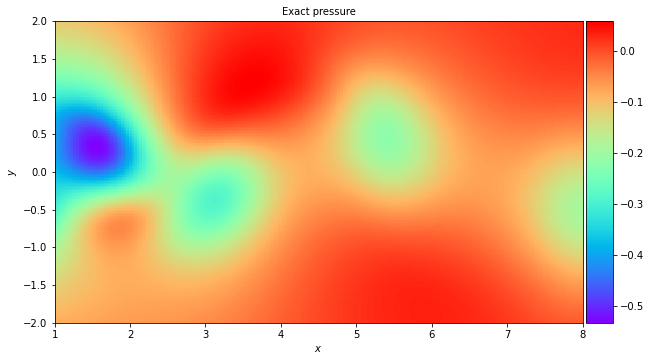

In [27]:
fig =  plt.figure(figsize=(10, 10))
gs = GridSpec(nrows = 1, ncols = 2)
ax = plt.subplot(111)
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()], 
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)

Text(0.5, 1.0, 'Predicted pressure')

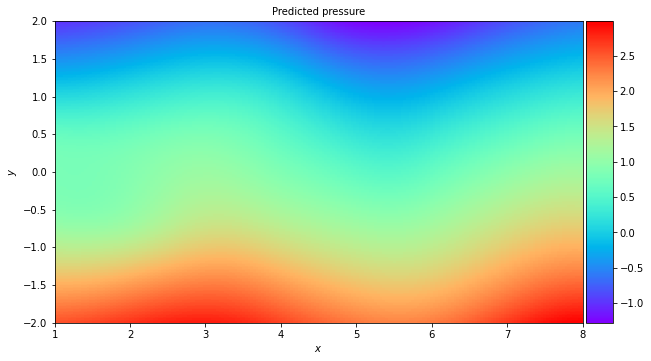

In [28]:
fig =  plt.figure(figsize=(10, 10))
gs = GridSpec(nrows = 1, ncols = 2)
ax = plt.subplot(111)
h = ax.imshow(P_pred, interpolation='nearest', cmap='rainbow', 
                extent=[x_test.min(), x_test.max(), y_test.min(), y_test.max()], 
                origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)


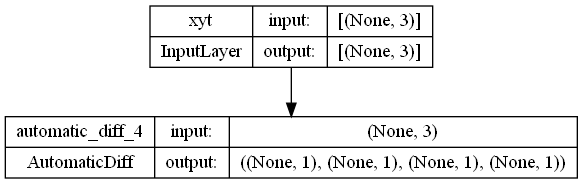

In [29]:
xyt = Input(shape = (3,), name = "xyt")

dnn = DNN()
pinn = PINN(dnn)

model = Model(inputs = xyt, outputs = pinn.call(xyt))
plot_model(model, show_shapes=True, show_layer_names=True)